In [1]:
import pandas as pd
import numpy as np

In [2]:
products = pd.read_csv("amazon_baby_subset.csv")
products.head()

,name,review,rating,sentiment
0,Stop Pacifier Sucking without tears with Thumb...,All of my kids have cried non-stop when I trie...,5,1
1,Nature's Lullabies Second Year Sticker Calendar,We wanted to get something to keep track of ou...,5,1
2,Nature's Lullabies Second Year Sticker Calendar,My daughter had her 1st baby over a year ago. ...,5,1
3,"Lamaze Peekaboo, I Love You","One of baby's first and favorite books, and it...",4,1
4,SoftPlay Peek-A-Boo Where's Elmo A Children's ...,Very cute interactive book! My son loves this ...,5,1


In [3]:
products['sentiment'].value_counts()

 1    26579
-1    26493
dtype: int64

##Reading important words

In [4]:
def read_index(filename):
    with open(filename, 'r') as f:
        first_line = f.readline()
    first_line = first_line.translate(None,'[]"').strip().split(',')
    first_line = [x.strip() for x in first_line]
    return first_line

In [5]:
important_words = read_index('important_words.json')
print important_words[:5]

['baby', 'one', 'great', 'love', 'use']


## Remove Punctuation

In [6]:
products = products.fillna({'review':''})  # fill in N/A's in the review column

In [7]:
import string

def remove_punctuation(text):
    if isinstance(text, str):
        return text.translate(None, string.punctuation)
    return str(text)

In [8]:
products['review_clean'] = products['review'].map(lambda s: remove_punctuation(s))
products.head()

,name,review,rating,sentiment,review_clean
0,Stop Pacifier Sucking without tears with Thumb...,All of my kids have cried non-stop when I trie...,5,1,All of my kids have cried nonstop when I tried...
1,Nature's Lullabies Second Year Sticker Calendar,We wanted to get something to keep track of ou...,5,1,We wanted to get something to keep track of ou...
2,Nature's Lullabies Second Year Sticker Calendar,My daughter had her 1st baby over a year ago. ...,5,1,My daughter had her 1st baby over a year ago S...
3,"Lamaze Peekaboo, I Love You","One of baby's first and favorite books, and it...",4,1,One of babys first and favorite books and it i...
4,SoftPlay Peek-A-Boo Where's Elmo A Children's ...,Very cute interactive book! My son loves this ...,5,1,Very cute interactive book My son loves this b...


## Adding word counts

In [9]:
for word in important_words:
    products[word] = products['review_clean'].apply(lambda s : s.split().count(word))

In [10]:
print products.columns.values[:5]

['name' 'review' 'rating' 'sentiment' 'review_clean']


In [13]:
train_idx = read_index('train-idx.json')
train_idx = [int(x) for x in train_idx]
valid_idx = read_index('validation-idx.json')
valid_idx = [int(x) for x in valid_idx]

In [17]:
print products.shape
print max(train_idx)
print max(valid_idx)

(53072, 198)
53070
53071


In [25]:
train_data = products.iloc[train_idx]
valid_data = products.iloc[valid_idx]

## Convert pandas to numpy array

In [26]:
def get_numpy_data(dataframe, features, label):
    dataframe['constant'] = 1
    features = ['constant'] + features
    features_frame = dataframe[features]
    feature_matrix = features_frame.as_matrix()
    label_sarray = dataframe[label]
    label_array = label_sarray.as_matrix()
    return(feature_matrix, label_array)

In [27]:
print type(train_data)
features_train, target_train = get_numpy_data(train_data, important_words, 'sentiment')
features_valid, target_valid = get_numpy_data(valid_data, important_words, 'sentiment')

<class 'pandas.core.frame.DataFrame'>


/Users/oleksiirenov/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from IPython.kernel.zmq import kernelapp as app


In [29]:
import math

def predict_probability(feature_matrix, coefficients):
    score = np.dot(feature_matrix, coefficients)
    predictions = map(lambda s: 1./(1.+math.exp(-s)), score)
    
    return predictions

##Compute derivative of log likelihood with respect to a single coefficient



In [44]:
def feature_derivative_with_l2(errors, feature, coefficient, l2_penalty, feature_is_constant):     
    derivative = np.sum(np.multiply(errors, feature))
    if not feature_is_constant:
        derivative -= 2*l2_penalty*coefficient
    
    return derivative

##Quiz question: In the code above, was the intercept term regularized?



No =)

## Log-likelihood function

In [34]:
def compute_log_likelihood(feature_matrix, sentiment, coefficients, l2_penalty):
    indicator = (sentiment==+1)
    scores = np.dot(feature_matrix, coefficients)
    lp = np.sum((indicator-1)*scores - np.log(1. + np.exp(-scores))) - l2_penalty * np.sum(coefficients[1:]**2)
    return lp

##Quiz question: Does the term with L2 regularization increase or decrease ℓℓ(w)?



Decreases

## Gradient Ascent with L2

In [42]:
from math import sqrt

def logistic_regression(feature_matrix, sentiment, initial_coefficients, step_size, l2_penalty, max_iter):
    coefficients = np.array(initial_coefficients) # make sure it's a numpy array
    for itr in xrange(max_iter):
        # Predict P(y_i = +1|x_1,w) using your predict_probability() function
        predictions = predict_probability(feature_matrix, coefficients)

        # Compute indicator value for (y_i = +1)
        indicator = (sentiment == +1)

        # Compute the errors as indicator - predictions
        errors = indicator - predictions

        for j in xrange(len(coefficients)): # loop over each coefficient
            # Recall that feature_matrix[:,j] is the feature column associated with coefficients[j]
            # compute the derivative for coefficients[j]. Save it in a variable called derivative
            is_intercept = (j == 0)
            derivative = feature_derivative_with_l2(errors, feature_matrix[:,j], coefficients[j], l2_penalty, is_intercept)
            # add the step size times the derivative to the current coefficient
            coefficients[j] += step_size * derivative

        # Checking whether log likelihood is increasing
        if itr <= 15 or (itr <= 100 and itr % 10 == 0) or (itr <= 1000 and itr % 100 == 0) \
        or (itr <= 10000 and itr % 1000 == 0) or itr % 10000 == 0:
            lp = compute_log_likelihood(feature_matrix, sentiment, coefficients, l2_penalty)
            print 'iteration %*d: log likelihood of observed labels = %.8f' % \
                (int(np.ceil(np.log10(max_iter))), itr, lp)
    return coefficients

## Explore effects of L2 coefficients

In [45]:
coefficients_0_penalty = logistic_regression(features_train, target_train, [0.] * features_train.shape[1],5e-6, 0, 501)

iteration   0: log likelihood of observed labels = -29179.39138303
iteration   1: log likelihood of observed labels = -29003.71259047
iteration   2: log likelihood of observed labels = -28834.66187288
iteration   3: log likelihood of observed labels = -28671.70781507
iteration   4: log likelihood of observed labels = -28514.43078198
iteration   5: log likelihood of observed labels = -28362.48344665
iteration   6: log likelihood of observed labels = -28215.56713122
iteration   7: log likelihood of observed labels = -28073.41743783
iteration   8: log likelihood of observed labels = -27935.79536396
iteration   9: log likelihood of observed labels = -27802.48168669
iteration  10: log likelihood of observed labels = -27673.27331484
iteration  11: log likelihood of observed labels = -27547.98083656
iteration  12: log likelihood of observed labels = -27426.42679977
iteration  13: log likelihood of observed labels = -27308.44444728
iteration  14: log likelihood of observed labels = -27193.8767

In [46]:
coefficients_4_penalty = logistic_regression(features_train, target_train, [0.] * features_train.shape[1],5e-6, 4, 501)

iteration   0: log likelihood of observed labels = -29179.39508175
iteration   1: log likelihood of observed labels = -29003.73417180
iteration   2: log likelihood of observed labels = -28834.71441858
iteration   3: log likelihood of observed labels = -28671.80345068
iteration   4: log likelihood of observed labels = -28514.58077957
iteration   5: log likelihood of observed labels = -28362.69830317
iteration   6: log likelihood of observed labels = -28215.85663259
iteration   7: log likelihood of observed labels = -28073.79071393
iteration   8: log likelihood of observed labels = -27936.26093762
iteration   9: log likelihood of observed labels = -27803.04751805
iteration  10: log likelihood of observed labels = -27673.94684207
iteration  11: log likelihood of observed labels = -27548.76901327
iteration  12: log likelihood of observed labels = -27427.33612958
iteration  13: log likelihood of observed labels = -27309.48101569
iteration  14: log likelihood of observed labels = -27195.0462

In [47]:
coefficients_10_penalty = logistic_regression(features_train, target_train, [0.] * features_train.shape[1],5e-6, 10, 501)

iteration   0: log likelihood of observed labels = -29179.40062984
iteration   1: log likelihood of observed labels = -29003.76654163
iteration   2: log likelihood of observed labels = -28834.79322654
iteration   3: log likelihood of observed labels = -28671.94687528
iteration   4: log likelihood of observed labels = -28514.80571589
iteration   5: log likelihood of observed labels = -28363.02048079
iteration   6: log likelihood of observed labels = -28216.29071186
iteration   7: log likelihood of observed labels = -28074.35036891
iteration   8: log likelihood of observed labels = -27936.95892966
iteration   9: log likelihood of observed labels = -27803.89576265
iteration  10: log likelihood of observed labels = -27674.95647005
iteration  11: log likelihood of observed labels = -27549.95042714
iteration  12: log likelihood of observed labels = -27428.69905549
iteration  13: log likelihood of observed labels = -27311.03455140
iteration  14: log likelihood of observed labels = -27196.7989

In [48]:
coefficients_1e2_penalty = logistic_regression(features_train, target_train, [0.] * features_train.shape[1],5e-6, 1e2, 501)

iteration   0: log likelihood of observed labels = -29179.48385120
iteration   1: log likelihood of observed labels = -29004.25177457
iteration   2: log likelihood of observed labels = -28835.97382190
iteration   3: log likelihood of observed labels = -28674.09410083
iteration   4: log likelihood of observed labels = -28518.17112932
iteration   5: log likelihood of observed labels = -28367.83774654
iteration   6: log likelihood of observed labels = -28222.77708939
iteration   7: log likelihood of observed labels = -28082.70799392
iteration   8: log likelihood of observed labels = -27947.37595368
iteration   9: log likelihood of observed labels = -27816.54738615
iteration  10: log likelihood of observed labels = -27690.00588850
iteration  11: log likelihood of observed labels = -27567.54970126
iteration  12: log likelihood of observed labels = -27448.98991327
iteration  13: log likelihood of observed labels = -27334.14912742
iteration  14: log likelihood of observed labels = -27222.8604

In [49]:
coefficients_1e3_penalty = logistic_regression(features_train, target_train, [0.] * features_train.shape[1],5e-6, 1e3, 501)

iteration   0: log likelihood of observed labels = -29180.31606471
iteration   1: log likelihood of observed labels = -29009.07176112
iteration   2: log likelihood of observed labels = -28847.62378912
iteration   3: log likelihood of observed labels = -28695.14439397
iteration   4: log likelihood of observed labels = -28550.95060743
iteration   5: log likelihood of observed labels = -28414.45771129
iteration   6: log likelihood of observed labels = -28285.15124375
iteration   7: log likelihood of observed labels = -28162.56976044
iteration   8: log likelihood of observed labels = -28046.29387744
iteration   9: log likelihood of observed labels = -27935.93902900
iteration  10: log likelihood of observed labels = -27831.15045502
iteration  11: log likelihood of observed labels = -27731.59955260
iteration  12: log likelihood of observed labels = -27636.98108219
iteration  13: log likelihood of observed labels = -27547.01092670
iteration  14: log likelihood of observed labels = -27461.4242

In [50]:
coefficients_1e5_penalty = logistic_regression(features_train, target_train, [0.] * features_train.shape[1],5e-6, 1e5, 501)

iteration   0: log likelihood of observed labels = -29271.85955115
iteration   1: log likelihood of observed labels = -29271.71006589
iteration   2: log likelihood of observed labels = -29271.65738833
iteration   3: log likelihood of observed labels = -29271.61189923
iteration   4: log likelihood of observed labels = -29271.57079975
iteration   5: log likelihood of observed labels = -29271.53358505
iteration   6: log likelihood of observed labels = -29271.49988440
iteration   7: log likelihood of observed labels = -29271.46936584
iteration   8: log likelihood of observed labels = -29271.44172890
iteration   9: log likelihood of observed labels = -29271.41670149
iteration  10: log likelihood of observed labels = -29271.39403722
iteration  11: log likelihood of observed labels = -29271.37351294
iteration  12: log likelihood of observed labels = -29271.35492661
iteration  13: log likelihood of observed labels = -29271.33809523
iteration  14: log likelihood of observed labels = -29271.3228

## Compare Coefficients

In [51]:
coefficients = list(coefficients_0_penalty[1:]) # exclude intercept
word_coefficient_tuples = [(word, coefficient) for word, coefficient in zip(important_words, coefficients)]
word_coefficient_tuples = sorted(word_coefficient_tuples, key=lambda x:x[1], reverse=True)

In [56]:
positive_words = [x[0] for x in word_coefficient_tuples[:5]]
print positive_words

['love', 'loves', 'easy', 'perfect', 'great']


In [57]:
negative_words = [x[0] for x in word_coefficient_tuples[-5:]]
print negative_words

['returned', 'waste', 'return', 'money', 'disappointed']


# Plot coefficient paths

In [58]:
l2_penalty_list = [0, 4, 10, 1e2, 1e3, 1e5]

In [74]:
positive_words_idx = [important_words.index(x) + 1 for x in positive_words]
negative_words_idx = [important_words.index(x) + 1 for x in negative_words]

In [75]:
list_coefs = [coefficients_0_penalty, coefficients_4_penalty, coefficients_10_penalty, \
             coefficients_1e2_penalty, coefficients_1e3_penalty, coefficients_1e5_penalty]

In [76]:
table = {}

In [77]:
for t, word in enumerate(positive_words):
    table[word] = [x[positive_words_idx[t]] for x in list_coefs]

for t, word in enumerate(negative_words):
    table[word] = [x[negative_words_idx[t]] for x in list_coefs]

In [78]:
table

{'disappointed': [-0.95543662817072728,
  -0.94697991825871808,
  -0.93451841994063234,
  -0.77562513654578802,
  -0.26609518179599079,
  -0.0040133965788233901],
 'easy': [0.98455881987319238,
  0.97760014978170362,
  0.96736183663147013,
  0.83824483295545049,
  0.40190397136319128,
  0.0088076812121040803],
 'great': [0.8016249897781762,
  0.79689693300330866,
  0.78993514722140434,
  0.70142507367483375,
  0.37601171422167079,
  0.0089495604973556398],
 'love': [1.0585539820695435,
  1.0508556809936309,
  1.0395285158465859,
  0.89664413310107771,
  0.41835364413392689,
  0.0090417372976952879],
 'loves': [1.0524840477983537,
  1.0439029129020743,
  1.0312653468918702,
  0.87079397482252818,
  0.34587025662885307,
  0.0061498825557440798],
 'money': [-0.76879313461210519,
  -0.76273397639987306,
  -0.75381829398395606,
  -0.64140575248110454,
  -0.27588337391474488,
  -0.0054872104550905791],
 'perfect': [0.83569320763834642,
  0.82855467479115485,
  0.81803783754282045,
  0.684142

## GOGO

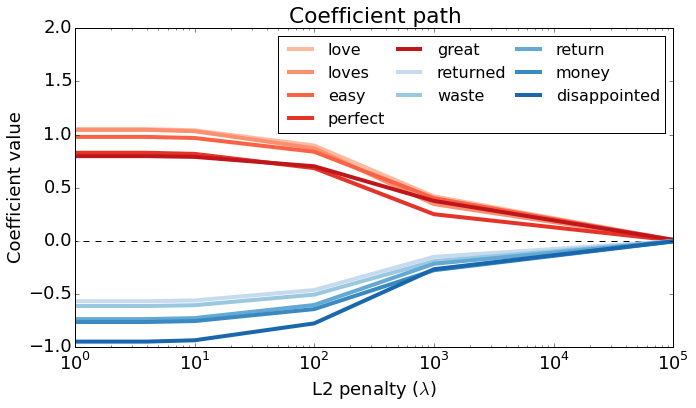

In [79]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = 10, 6

def make_coefficient_plot(table, positive_words, negative_words, l2_penalty_list):
    cmap_positive = plt.get_cmap('Reds')
    cmap_negative = plt.get_cmap('Blues')
    
    xx = l2_penalty_list
    plt.plot(xx, [0.]*len(xx), '--', lw=1, color='k')
    
    for i,word in enumerate(positive_words):
        color = cmap_positive(0.8*((i+1)/(len(positive_words)*1.2)+0.15))
        plt.plot(xx, table[word], '-', label=positive_words[i], linewidth=4.0, color=color)
        
    for i,word in enumerate(negative_words):
        color = cmap_negative(0.8*((i+1)/(len(negative_words)*1.2)+0.15))
        plt.plot(xx, table[word], '-', label=negative_words[i], linewidth=4.0, color=color)
        
    plt.legend(loc='best', ncol=3, prop={'size':16}, columnspacing=0.5)
    plt.axis([1, 1e5, -1, 2])
    plt.title('Coefficient path')
    plt.xlabel('L2 penalty ($\lambda$)')
    plt.ylabel('Coefficient value')
    plt.xscale('log')
    plt.rcParams.update({'font.size': 18})
    plt.tight_layout()


make_coefficient_plot(table, positive_words, negative_words, l2_penalty_list=[0, 4, 10, 1e2, 1e3, 1e5])

##Quiz Question: (True/False) All coefficients consistently get smaller in size as L2 penalty is increased.

##Quiz Question: (True/False) Relative order of coefficients is preserved as L2 penalty is increased. (If word 'cat' was more positive than word 'dog', then it remains to be so as L2 penalty is increased.)

1) True
2) False

## Measuring Accuracy

##Quiz question: Which model (L2 = 0, 4, 10, 100, 1e3, 1e5) has the highest accuracy on the training data?

In [80]:
l2_penalty_list = [0, 4, 10, 1e2, 1e3, 1e5]
list_coefs = [coefficients_0_penalty, coefficients_4_penalty, coefficients_10_penalty, \
             coefficients_1e2_penalty, coefficients_1e3_penalty, coefficients_1e5_penalty]

In [86]:
def accuracy(true_label, predicted_label):
    return sum(true_label == predicted_label) / float(len(true_label))

In [87]:
def predict_log_reg(feature_matrix, coefficients):
    scores = np.dot(feature_matrix, coefficients)
    predictions = map(lambda s : 1 if s > 0 else -1, scores)
    return predictions

In [88]:
[{'l2_penalty' : l2_penalty, 'accuracy' : accuracy(target_train, predict_log_reg(features_train, coefs))} for l2_penalty, coefs in zip(l2_penalty_list, list_coefs)]

[{'accuracy': 0.78515615778664338, 'l2_penalty': 0},
 {'accuracy': 0.78510894454805125, 'l2_penalty': 4},
 {'accuracy': 0.78499091145157107, 'l2_penalty': 10},
 {'accuracy': 0.78397582682184086, 'l2_penalty': 100.0},
 {'accuracy': 0.77585514978399939, 'l2_penalty': 1000.0},
 {'accuracy': 0.68036637473147465, 'l2_penalty': 100000.0}]

##Quiz question: Which model (L2 = 0, 4, 10, 100, 1e3, 1e5) has the highest accuracy on the validation data?

In [89]:
[{'l2_penalty' : l2_penalty, 'accuracy' : accuracy(target_valid, predict_log_reg(features_valid, coefs))} for l2_penalty, coefs in zip(l2_penalty_list, list_coefs)]

[{'accuracy': 0.78143964149005696, 'l2_penalty': 0},
 {'accuracy': 0.78153300345439269, 'l2_penalty': 4},
 {'accuracy': 0.78171972738306417, 'l2_penalty': 10},
 {'accuracy': 0.78106619363271401, 'l2_penalty': 100.0},
 {'accuracy': 0.7713565493417982, 'l2_penalty': 1000.0},
 {'accuracy': 0.66781813089347397, 'l2_penalty': 100000.0}]

##Quiz question: Does the highest accuracy on the training data imply that the model is the best one?


No